<a href="https://colab.research.google.com/github/cristianokunas/Sentiment_Analysis/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!nvidia-smi

Mon Apr 13 02:58:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    31W / 250W |   1421MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Required Downloads

In [0]:
!pip install nltk

In [0]:
#!pip install tensorflow==1.14.0
!pip install tensorflow
#!pip install --upgrade tensorflow

In [0]:
#!pip install tensorflow-gpu==1.14.0
!pip install --upgrade tensorflow-gpu

In [0]:
import nltk
nltk.download('stopwords')

# Etapa 1 - Importing the libraries

In [0]:
import os
import re
import time
import zipfile

import numpy as np
import pandas as pd
from keras.layers import Dense, Input
from keras.layers import Embedding
from keras.layers import LSTM  # , Bidirectional
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Etapa 2 - Connecting to Drive and accessing files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = "/content/drive/My Drive/Lab/Data Science/Sentiment Analysis/IMDB/github/imdb.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("/content/drive/My Drive/Lab/Data Science/Sentiment Analysis/IMDB/github")
zip_object.close

# Etapa 3 - Accessing the review database

In [0]:
# Carrega o arquivo de dados .csv
data = pd.read_csv('/content/drive/My Drive/Lab/Data Science/Sentiment Analysis/IMDB/github/imdb.csv')
data.head()

In [0]:
data.tail()

In [0]:
plt.figure(figsize=(4, 2.5))
plt.plot(data['sentiment'], lw=2.0, color='b')
plt.title('Divisão das Reviews por Sentimento')
plt.xlabel('Número de Reviews')
plt.ylabel('Sentimento')
plt.show()

# Etapa 4 - Initializes variables

In [0]:
seed = 7
np.random.seed(seed)
# O model sera exportado para este arquivo
filename = '/content/drive/My Drive/Lab/Data Science/Sentiment Analysis/model_saved.h5'
# numero de iteracoes
epochs = 5  # email - 150
# numero de amostras a serem utilizadas em cada atualizacao do gradiente - numero de instancias
batch_size = 32  # email - 10
# separa % para teste do modelo
test_dim = 0.20
# Quantidade maxima de palavras para manter no vocabulario
max_features = 5000
# dimensao de saida da camada Embedding
embed_dim = 128
# Tamanho maximo das sentencas
max_sequence_length = 300

# Calculating Runtime

In [0]:
def calcRuntime(totalTime):
  hours, rem = divmod(totalTime, 3600)
  minutes, seconds = divmod(rem, 60)
  formatTime = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
  return formatTime

# Etapa 5 - Data pre-processing

In [0]:
# metodo para limpar as strings - tirar conteudo que nao agrega
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')

    return string.strip().lower()

In [0]:
# Metodo para preparar os dados de treino e teste
# carrega csv, limpa as strings e remove as stop_wors
# Realiza a tokenizacao
def prepare_data(data):
    data = data[['text', 'sentiment']]
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].apply(lambda x: clean_str(x))
    data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

    stop_words = set(stopwords.words('english'))
    text = []
    for row in data['text'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)

    tokenizer = Tokenizer(num_words=max_features, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)

    X = pad_sequences(X, maxlen=max_sequence_length)

    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_dim, random_state=42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer

# Etapa 6 - Create model and training the network

In [0]:
# chama metodo para preparar dados
X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Cria o modelo
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=max_sequence_length))
model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm"))
#model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
#model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(2, kernel_initializer='uniform', activation='sigmoid'))

# compila o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [153]:
# chama metodo para preparar dados
X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Cria o modelo
input_shape = (max_sequence_length,)
model_input = Input(shape=input_shape, name="input", dtype='int32')
embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
model_output = Dense(2, activation='softmax', name="softmax")(lstm)
model = Model(inputs=model_input, outputs=model_output)

# compila o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

(40000, 300) (40000, 2)
(10000, 300) (10000, 2)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
softmax (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Treinamento da rede neural
# Verifica se existe um modelo treinado
# True = carrega o modelo ja treinado
# False = treina a rede e salva o modelo
inicio = time.time()

if os.path.exists('{}'.format(filename)):
  try:
    model.load_weights('{}'.format(filename))
    print('Successful model loading!')
  except:
    print('No such file or directory!')
else:
  hist = model.fit(
      X_train,
      Y_train,
      validation_data=(X_test, Y_test),
      epochs=epochs,
      batch_size=batch_size, 
      shuffle=True,
      verbose=1)
  
  model.save_weights(filename)

fim = time.time()
print(calcRuntime(fim - inicio))

# Etapa 7 - Evaluate model / Validate model with new entries

In [0]:
# Avaliando o modelo
scores = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Accuracy: %.2f%%" % (scores[1] * 100))
print("Erro: %.2f%%" % (scores[0] * 100))

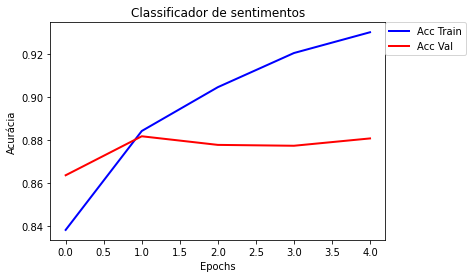

In [156]:
plt.figure()
#plt.axis([0, 4, 0, 1])
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='Acc Train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='Acc Val')
#plt.plot(hist.history['loss'], lw=2.0, color='darkviolet', label='Loss Train')
#plt.plot(hist.history['val_loss'], lw=2.0, color='lime', label='Loss Val')
plt.title('Classificador de sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.show()

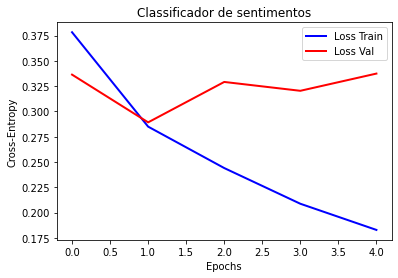

In [157]:
# Plot
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='Loss Train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='Loss Val')
plt.title('Classificador de sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.show()

In [0]:
while True:
    print("\nType 0 to quit")
    sentence = input("input> ")

    if sentence == "0":
        break

    new_text = [sentence]
    new_text = tokenizer.texts_to_sequences(new_text)

    new_text = pad_sequences(new_text, maxlen=max_sequence_length, dtype='int32', value=0)

    sentiment = model.predict(new_text, batch_size=1, verbose=2)[0]

    if (np.argmax(sentiment) == 0):
        pred_proba = "%.2f%%" % (sentiment[0] * 100)
        print("negativo => ", pred_proba)
    elif (np.argmax(sentiment) == 1):
        pred_proba = "%.2f%%" % (sentiment[1] * 100)
        print("positivo => ", pred_proba)


Review Original:
There isn't too much in the way of suspense or surprises when it comes to the story, but there are some shocking moments and funny lines in this epic finale. Again, like many of the best Marvel films, the holes and flaws are covered up with humor and fan service, making everything okay. That being said, I did prefer Infinity War to this film, which really misses the leads of the other Marvel franchises that were "snapped" out. Overall, however, there are only a few ways you can wrap up the main story of the MCU, and this was a solid direction.

Google Translate:
Não há muito suspense ou surpresas quando se trata da história, mas há alguns momentos chocantes e frases engraçadas neste final épico. Novamente, como muitos dos melhores filmes da Marvel, os buracos e as falhas são cobertos com humor e serviço de fãs, deixando tudo bem. Dito isto, eu preferi a Guerra do Infinito a este filme, que realmente sente falta das pistas de outras franquias da Marvel que foram "quebradas". No geral, no entanto, existem apenas algumas maneiras de resumir a história principal do MCU, e essa foi uma direção sólida.

Opinião: 8/10 estrelas

Review Original:
I had no choice but to watch it to finish the sequence. The worst of all the Avengers movies. Apart from some action scenes all the rest it is pure lame dialogues and poor performances. Purely made to make money out of a "trendy" public that are rating this movie high because I've never met one single person who has read the comics and like this garbage. At least, there will be no more of this, I hope.

Google Translate:
Eu não tive escolha, mas assisti-lo para terminar a sequência. O pior de todos os filmes dos Vingadores. Além de algumas cenas de ação, o resto são diálogos coxos e performances ruins. Puramente feito para ganhar dinheiro com um público "na moda" que está avaliando este filme como alto porque nunca conheci uma única pessoa que leu os quadrinhos e gostou desse lixo. Pelo menos, não haverá mais isso, espero.

Opinião: 1/10 estrelas

# Final - Unmount Drive

In [0]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')